*Introduction*

_Schistosoma mansoni_ is a parasitic worm with a life cycle that involves a human and a snail host. In the humans, the adult worms will lay eggs in the blood vessels around the intestines. In which many of the eggs are passed to continue their cycle. However, some eggs become trapped in the liver, where they eventually die. Although they don't finish development these eggs trapped in the liver remain transcriptionally active and have been used in research for many years. Because they are a lot easier to collect rather than intestinal eggs. If eggs trapped in the liver differ significantly in their gene expression compared to intestinal eggs. Then the findings from years of research based soley on the liver eggs might not accurately reflect the findings of those studies. To see whether there are significant transcriptomic differences between _Schistosoma mansoni_ eggs located in the liver and intestines we used RNA sequencing with the help of bioinformatics tools. These will help determine if liver worm samples are a reliable for studying the parasite's stages.

*Methods*

RNA extraction, library preparation, and sequencing. (This will be written by Dr. Wheeler)

Read QC and alignment

Next we QC the prevousilty trimmed dataset using "FastQC version 0.12.1 and MultiQC version 1.25.2." QC was performed on the data to see which samples could be used. Using "STAR version 2.7.11b" they were aligned with the starting genome to see how much variance was between the liver and intestine groups.​ After aligning we then removed any duplicate sequences using "picard version 2.3." This was useful so we didn't count the same data twice leading to large amounts of duplication. Lastly we used "RScript version 4.3.3" to use differential expression on the PCA tests to see where there would be high concentrations of groups.​ Then we analyzed the data to create our desired charts and graphs.

Identification of differentially expressed genes and GO analysis

RNA counts were used in R by removing genes with zero counts in all of the samples. The provided matrix was used for differential expression using "DESeq2 v1.46.0." Genes with an absolute value of log2 fold change was greater than 2 and an adjusted p-value of 0.05 or less was considered significantly differentially expressed. These genes were then sent to gProfiler2 "v0.2.3." for enrichment analysis.

*Results*

RNA sequencing, alignment, and sample clustering

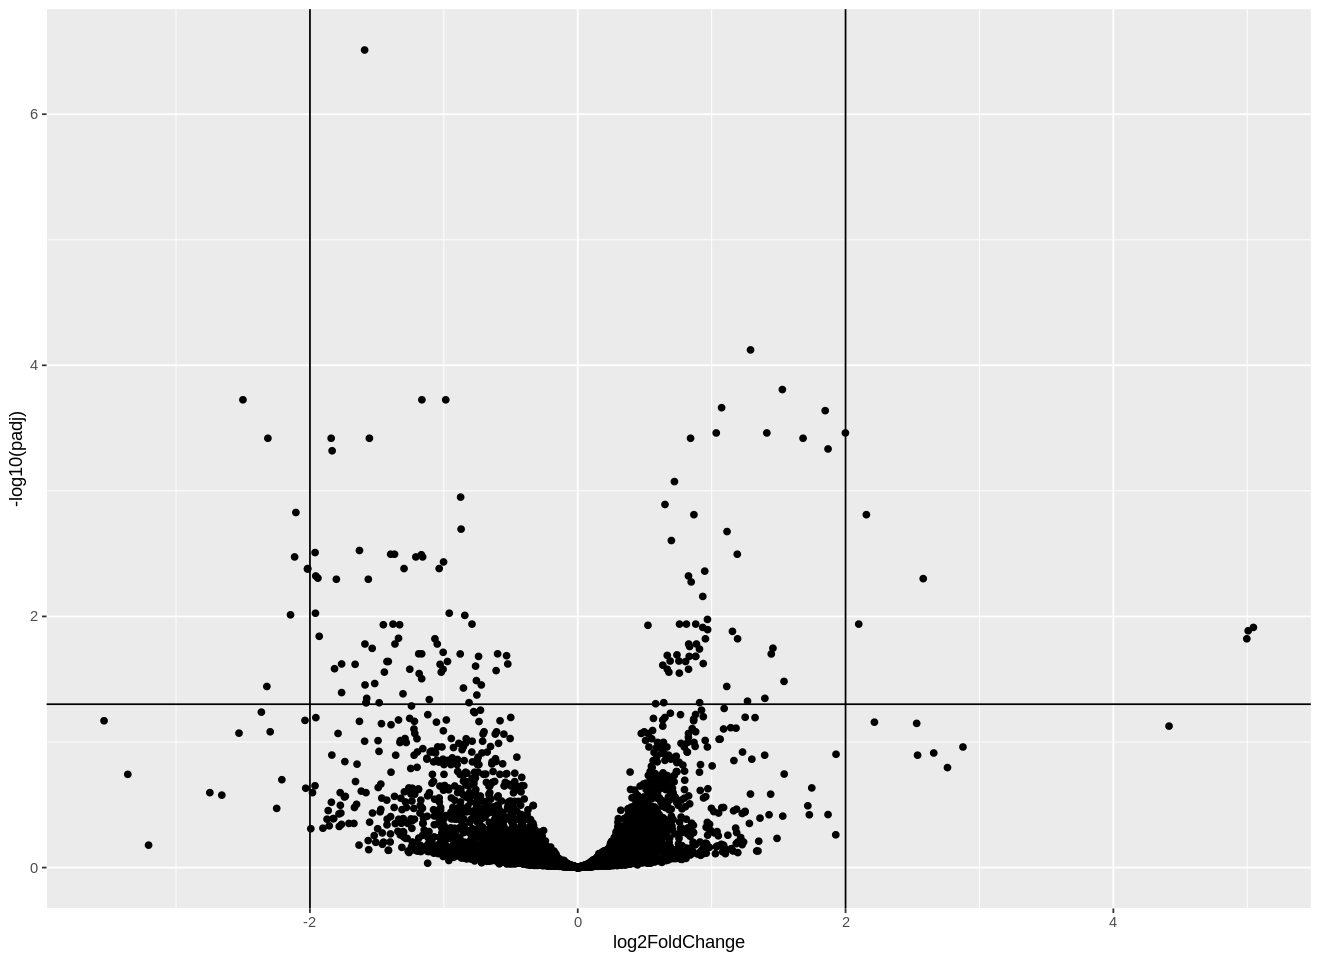

In [7]:
library(tidyverse)
library(gprofiler2)
library(ggplot2)
library(broom)
library(DESeq2)
library(gridExtra)

counts_df <- read_tsv('/data/classes/2025/spring/biol443/course_files/rnaseq_data/counts.tsv', comment = '#', show_col_types = FALSE) |>
             mutate(across(where(is.numeric), as.integer))

counts_summary <- counts_df |>
    select(Geneid, contains('.bam')) |>
    rename_with(~str_remove(., "dedup/star/.*:"), everything()) |>
    rowwise() |>
    mutate(total_counts = sum(c_across(where(is.numeric)), na.rm = T)) |>
    filter(total_counts >= 10)

sample_summary <- counts_df |>
    select(Geneid, contains('.bam')) |>
    rename_with(~str_remove(., "dedup/star/.*:"), everything()) |>
    pivot_longer(-Geneid, names_to = 'sample', values_to = 'count') |>
    filter(count > 0) |>
    group_by(Geneid) |>
    tally() |>
    filter(n <= 3)

genes_to_remove = sample_summary$Geneid

counts_filt <- counts_summary |>
    filter(!Geneid %in% genes_to_remove) |>
    arrange(Geneid) |>
    select(-total_counts)

counts_m <- counts_filt |>
    select(-Geneid) |>
    as.matrix()
rownames(counts_m) <- counts_filt$Geneid

metadata <- data.frame(sample_id = colnames(counts_m)) |>
    mutate(tissue = str_sub(sample_id, 1, 3),
           rep = str_sub(sample_id, 5))
rownames(metadata) <- metadata$sample_id
metadata <- select(metadata, -sample_id)

dds <- suppressWarnings({
    DESeqDataSetFromMatrix(countData = counts_m,
                              colData = metadata,
                              design = ~ tissue)})
dds <- DESeq(dds, quiet = TRUE)
res <- results(dds)
volcano_data <- as_tibble(res, rownames = 'gene_id')
options(repr.plot.width = 11, repr.plot.height = 8)
volcano_plot <- volcano_data |> 
    ggplot(aes(x = log2FoldChange, y = -log10(padj))) +
    geom_point(na.rm = TRUE) +
    geom_vline(xintercept = 2) +
    geom_vline(xintercept = -2) +
    geom_hline(yintercept = -log10(0.05))
volcano_plot

The volcano plot shows the 14 genes in the miracidia from the liver and intestian tissue types are significantly differentially expressed. Which meanes that these genes meet the criteria of having a –log10(padj) greater than –log10(0.05) and an absolute log2 fold change greater than 2.

Identification of differentially expressed genes

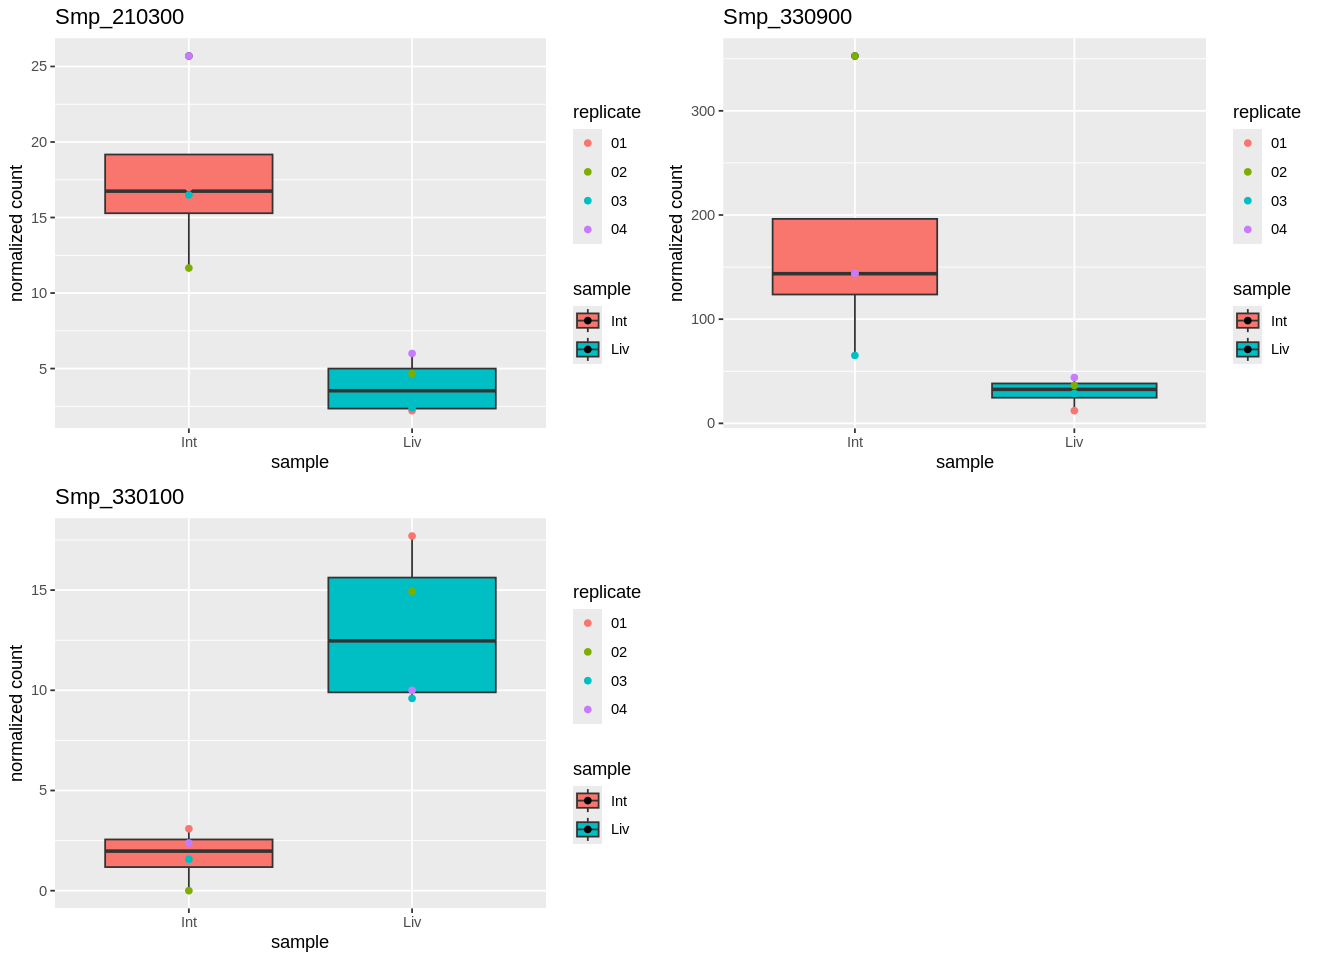

In [10]:
norm_counts <- read_csv('/data/classes/2025/spring/biol443/course_files/rnaseq_data/deseq_norm_counts.csv', show_col_types = FALSE)
degs <- read_csv('/data/classes/2025/spring/biol443/course_files/rnaseq_data/deseq_results.csv', show_col_types = FALSE)

degs_filtered <- degs |>
    filter(padj <= 0.05) |>
    filter(abs(log2FoldChange) > 2)

norm_counts_filtered <- norm_counts |>
    filter(gene_id %in% degs_filtered$gene_id)

norm_counts_filtered_long <- norm_counts_filtered |>
    pivot_longer(-gene_id, names_to = 'sample', values_to = 'norm_count') |>
    mutate(sample = str_remove(sample, "_S[0-9]{2}_L005")) |>
    separate(sample, c('sample', 'replicate'), "-")

plot1 <- norm_counts_filtered_long |>
    filter(gene_id == 'Smp_210300') |>
    ggplot(aes(x = sample, y = norm_count, fill = sample)) +
    geom_boxplot() +
    geom_point(aes(color = replicate)) +
    ggtitle("Smp_210300") +
    labs(y = "normalized count")

plot2 <- norm_counts_filtered_long |>
    filter(gene_id == 'Smp_330900') |>
    ggplot(aes(x = sample, y = norm_count, fill = sample)) +
    geom_boxplot() +
    geom_point(aes(color = replicate)) +
    ggtitle("Smp_330900") +
    labs(y = "normalized count")

plot3 <- norm_counts_filtered_long |>
    filter(gene_id == 'Smp_330100') |>
    ggplot(aes(x = sample, y = norm_count, fill = sample)) +
    geom_boxplot() +
    geom_point(aes(color = replicate)) +
    ggtitle("Smp_330100") +
    labs(y = "normalized count")

options(repr.plot.width = 11, repr.plot.height = 8)
grid.arrange(plot1, plot2, plot3, nrow = 2)

The boxplots show 3 of the 14 possible genes that are significantly differentially expressed, that have a padj value of < 0.05 and an absolute log2 fold change larger than 2. Each point on the boxplots shows an individual sample in which the gene was shown.

Identification of pathways and/or GO annotations that are differentially expressed

Rows: 8556 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): gene_id
dbl (6): baseMean, log2FoldChange, lfcSE, stat, pvalue, padj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


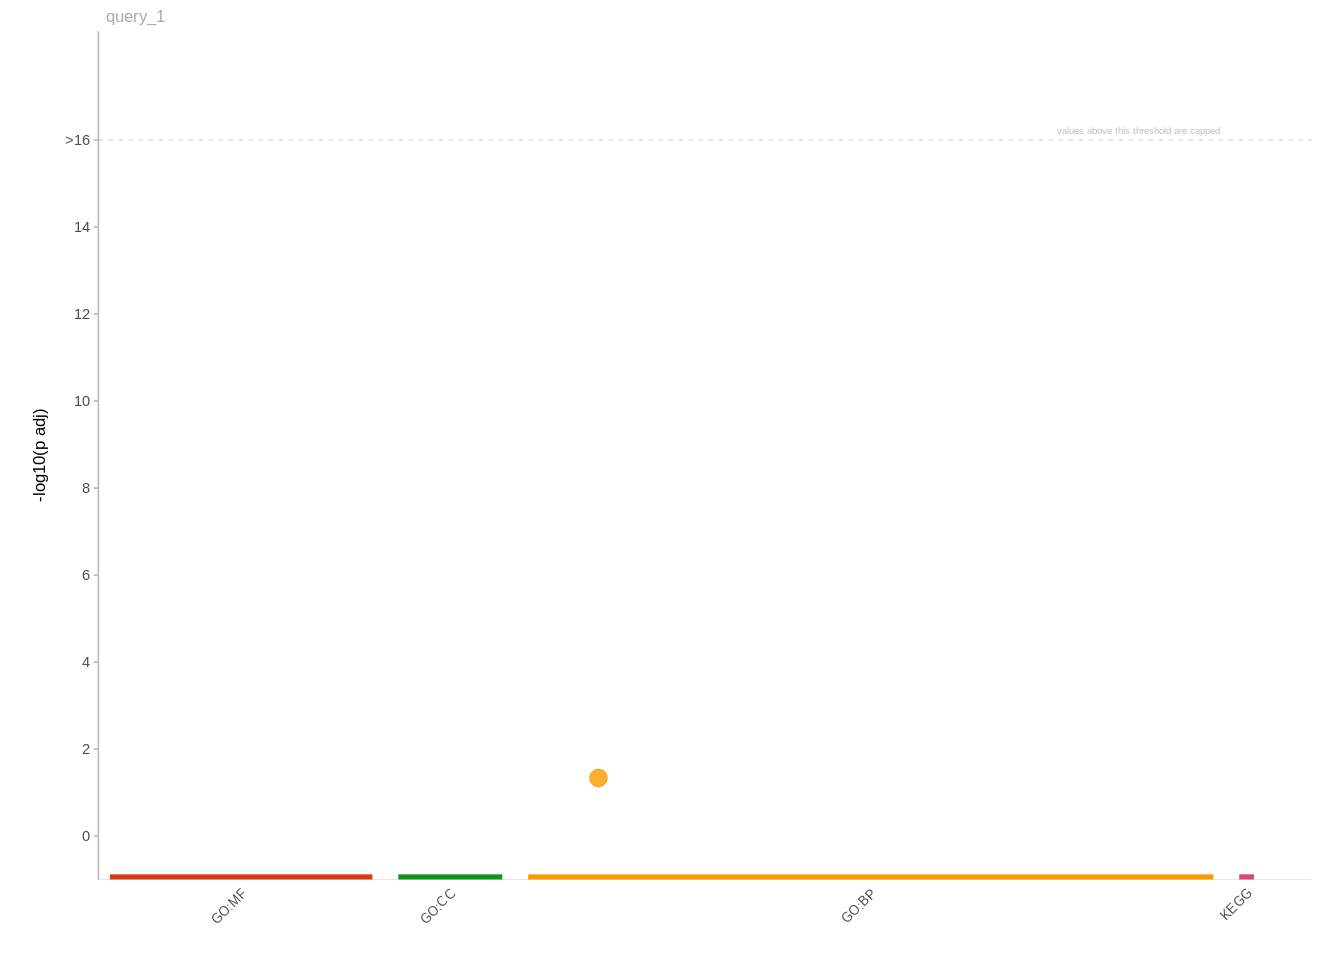

In [15]:
degs <- read_csv("/data/classes/2025/spring/biol443/course_files/rnaseq_data/deseq_results.csv")|>
    filter(padj<=0.05, abs(log2FoldChange)>2)
genes <- degs$gene_id

gostres <- gost(query=genes,
            organism = "smansoni")
            gostplot(gostres, interactive=FALSE)+
 labs(y= "-log10(p adj)")

ggsave("gProfile.png", dpi = 500, width = 14, height = 7)

The GO analysis identified one statistically significant gene among all the genes with padj < 0.05 and an absolute log2 fold change greater than 2.

*Discussion*

The research showed that _S. mansoni_ coming from the liver show a significant differences in genetic expression when compared to the intestines. In the future it would be interesting to investigate whether _S mansoni_ from the liver and intestines continue to show gene expression differences later in their life cycle. Since most prior experiments involving _S. mansoni_ have focused on specimens from the liver it’s important to determine whether or not those findings hold true for parasites from the intestines the ones that actually go on to complete the life cycle.

*References*

2018 Open OnDemand: A web-based client portal for HPC
centers. Available at:
https://joss.theoj.org/papers/10.21105/joss.00622.​

2019 STARmanual2.7.0a. Available at:
https://physiology.med.cornell.edu/faculty/skrabanek/lab/angs
d/lecture_notes/STARmanual.pdf. ​